# Max Cut

- https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm#step-1-map-classical-inputs-to-a-quantum-problem

In [77]:
from qiskit.quantum_info import SparsePauliOp
from sympy.printing import latex
from IPython.display import display, Math
from sympy import Matrix
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from sympy import eye, Matrix
from sympy.physics.quantum import TensorProduct

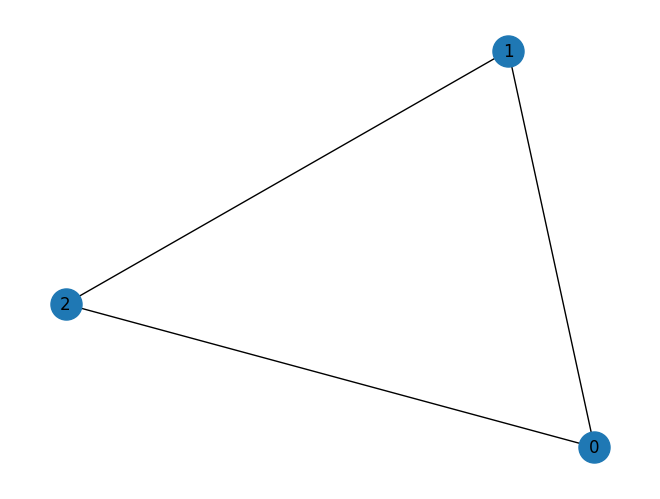

In [78]:
n = 3

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=500, with_labels=True)

In [79]:
# Matriz de adjacência (numpy.ndarray)
A = rx.adjacency_matrix(graph, weight_fn=float)

display(Math(r"A=" + latex(Matrix(A))))

# Matriz de grau (diagonal)
degrees = np.array(A.sum(axis=1)).flatten()
D = np.diag(degrees)

display(Math(r"D=" + latex(Matrix(D))))

# Laplaciano
L = D - A

display(Math(r"L=" + latex(Matrix(L))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [80]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

        print(edge,": ", paulis)

    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)

print("\nmax_cut_paulis: ", max_cut_paulis)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)

display(Math(r"H_C=" + latex(Matrix(cost_hamiltonian.to_matrix()))))

(0, 1) :  ['Z', 'Z', 'I']
(0, 2) :  ['Z', 'I', 'Z']
(1, 2) :  ['I', 'Z', 'Z']

max_cut_paulis:  [('IZZ', 1.0), ('ZIZ', 1.0), ('ZZI', 1.0)]


<IPython.core.display.Math object>

O Hamiltoniano $H_c=\sum_{i<j}Q_{ij}Z_iZ_j + \sum_{i}b_iZ_i$ é dado por

$$
H_C = Q_{01}Z_0Z_1I + Q_{02}Z_0IZ_2 + Q_{12}IZ_1Z_2 + b_0Z_0II + b_1IZ_1I + b_2IIZ_2
$$

como $Q_{ij}=1$ e $Z_i=Z$ e para o problema do Max-Cut podemos tomar $b_i=0$

- Se $b_i > 0$, então o sistema prefere que $x_i = 1$ $\Rightarrow$ o vértice $i$ tende a estar \textbf{no lado "1" do corte}
- Se $b_i < 0$, então o sistema prefere que $x_i = 0$ $\Rightarrow$ o vértice $i$ tende a estar \textbf{no lado "0" do corte}

Em outras palavras, adicionar um bias $b_i$ é equivalente a "puxar" o vértice $i$ para um lado específico do corte.

Observações feitas, temos então

$$
H_C = ZZI + ZIZ + IZZ
$$

In [89]:
# Define Pauli matrices
Z = Matrix([[1, 0], [0, -1]])
I = eye(2)

# Construct each term (3-qubit operators)
ZZI = TensorProduct(Z, Z, I)
ZIZ = TensorProduct(Z, I, Z)
IZZ = TensorProduct(I, Z, Z)

display(Math(r"H_C=" + latex(ZZI) + "+" + latex(ZIZ)+ "+" + latex(ZIZ) +'='+ latex(ZZI + ZIZ + IZZ)))

<IPython.core.display.Math object>

Este Hamiltoniano tem a propriedade que seu estado base corresponde à solução que minimiza $f(x)$. Basta então construir um circuito que prepara o estado base de $H_c$.

Vamos associar cada vértice com um estado $\ket{0}$ ou $\ket{1}$, onde cada valor denota o conjunto em que o vértice está. Nosso objetivo, é maximizar o número de arestas $(v_1, v_2)$ para o qual $v_1=\ket{0}$ e $v_2=\ket{1}$, ou vice-versa.

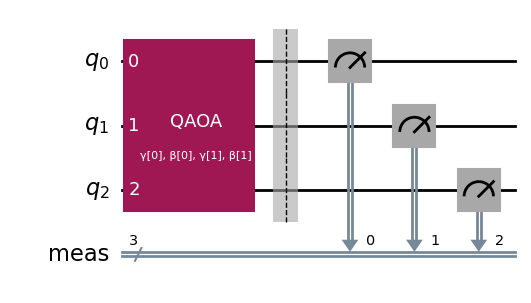

In [82]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [83]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [84]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

/tmp/ipykernel_94539/886047420.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel='ibm_quantum')


IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum.ibm.com/api/users/loginWithToken. This version of platform has been sunset. Create an account or sign in to the upgraded IBM Quantum Platform at https://quantum.cloud.ibm.com, Error code: 3447.'

In [ ]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [ ]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [ ]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/home/marcio/repositories/personal/qc-examples/venv/lib/python3.12/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''